## **CIFAR-10 Convolutional Autoencoder**

**Imports**

In [63]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from google.colab import drive
import os

**Parameters**

In [80]:
epochs = 25
batch_size = 128
buffer_size = 1024
AUTOTUNE = tf.data.AUTOTUNE

**Load and Preprocess the Dataset**

In [86]:
(train_dataset, test_dataset), info = tfds.load("cifar10", split=["train", "test"], as_supervised=True, with_info=True)
info

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir='/root/tensorflow_datasets/cifar10/3.0.2',
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learni

In [87]:
def preprocessing(image, label):
  image = tf.cast(image, dtype=tf.float32) / 255
  return image, image

In [88]:
train_dataset = (train_dataset
                 .map(preprocessing, num_parallel_calls=AUTOTUNE)
                 .shuffle(buffer_size, seed=123)
                 .batch(batch_size)
                 .prefetch(AUTOTUNE))

test_dataset = (test_dataset
                .map(preprocessing, num_parallel_calls=AUTOTUNE)
                .batch(batch_size)
                .prefetch(AUTOTUNE))

In [89]:
for im, im2 in train_dataset.take(1):
  print(im.shape)

(128, 32, 32, 3)


In [90]:
im.numpy().min(), im.numpy().max()

(0.0, 1.0)

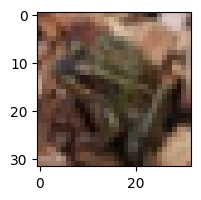

In [91]:
plt.figure(figsize=(2, 2))
plt.imshow(im[0]);

**Build the Model**

In [92]:
tf.keras.backend.clear_session()

In [93]:
def build_autoencoder():
  input = tf.keras.Input((32, 32, 3))

  # Encoder
  x = tf.keras.layers.Conv2D(64, kernel_size=(3,3), padding="same", activation="relu")(input)
  x = tf.keras.layers.MaxPooling2D((2,2))(x)

  x = tf.keras.layers.Conv2D(128, kernel_size=(3,3), padding="same", activation="relu")(x)
  x = tf.keras.layers.MaxPooling2D((2,2))(x)

  # Bottleneck
  x = tf.keras.layers.Conv2D(256, kernel_size=(3,3), padding="same", activation="relu")(x)
  encoder_visualization = tf.keras.layers.Conv2D(3, kernel_size=(3,3), padding="same", activation="sigmoid")(x)

  # Decoder
  x = tf.keras.layers.Conv2D(128, kernel_size=(3,3), padding="same", activation="relu")(x)
  x = tf.keras.layers.UpSampling2D((2,2))(x)

  x = tf.keras.layers.Conv2D(64, kernel_size=(3,3), padding="same", activation="relu")(x)
  x = tf.keras.layers.UpSampling2D((2,2))(x)

  x = tf.keras.layers.Conv2D(3, kernel_size=(3,3), padding="same", activation="sigmoid")(x) #Pixel values vary from 0 (black) to 1 (white) on all 3 channels

  # Models
  encoder_model = tf.keras.Model(inputs=input, outputs=encoder_visualization)
  autoencoder_model = tf.keras.Model(inputs=input, outputs=x)

  return encoder_model, autoencoder_model

In [94]:
tf.random.set_seed(123) #for reproducibility

encoder_model, autoencoder_model = build_autoencoder()
autoencoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 128)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         2951

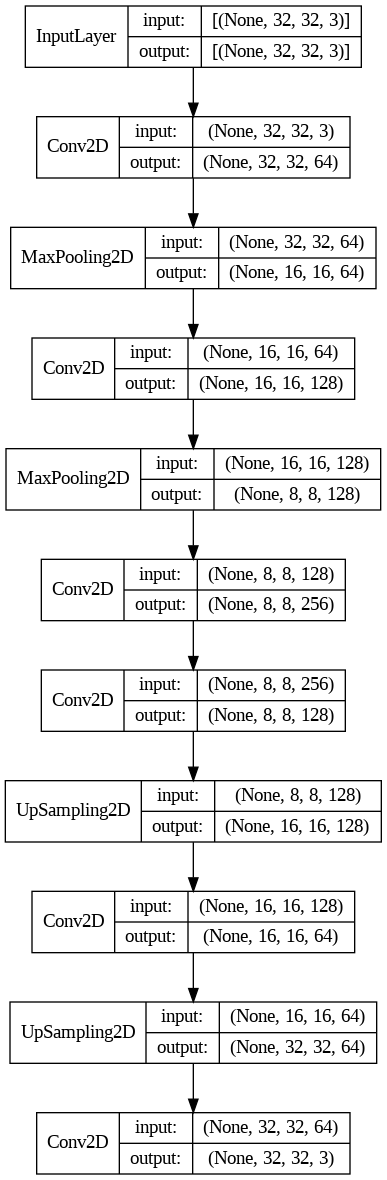

In [95]:
# Autoencoder architecture
tf.keras.utils.plot_model(autoencoder_model, show_shapes=True, show_layer_names=False)

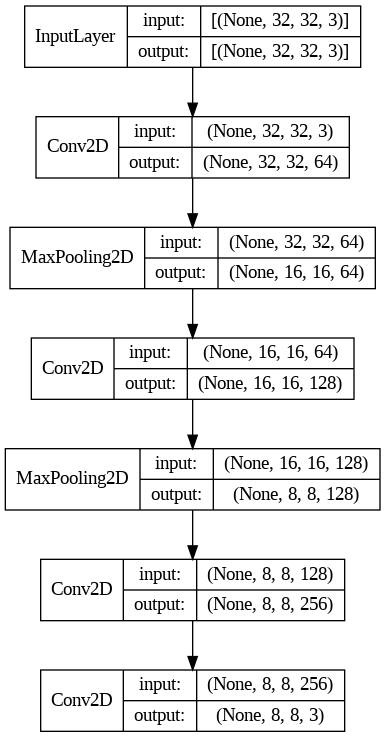

In [96]:
# Encoder architecture
tf.keras.utils.plot_model(encoder_model, show_shapes=True, show_layer_names=False)

**Compile and Train the Model**

In [97]:
autoencoder_model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss="binary_crossentropy")

In [98]:
history = autoencoder_model.fit(train_dataset, validation_data=test_dataset, epochs=epochs, verbose=1)

Epoch 1/25
391/391 [==============================] - 18s 37ms/step - loss: 0.5759 - val_loss: 0.5607
Epoch 2/25
391/391 [==============================] - 10s 25ms/step - loss: 0.5583 - val_loss: 0.5603
Epoch 3/25
391/391 [==============================] - 10s 24ms/step - loss: 0.5569 - val_loss: 0.5564
Epoch 4/25
391/391 [==============================] - 9s 23ms/step - loss: 0.5557 - val_loss: 0.5557
Epoch 5/25
391/391 [==============================] - 10s 25ms/step - loss: 0.5548 - val_loss: 0.5552
Epoch 6/25
391/391 [==============================] - 8s 21ms/step - loss: 0.5540 - val_loss: 0.5541
Epoch 7/25
391/391 [==============================] - 10s 24ms/step - loss: 0.5535 - val_loss: 0.5536
Epoch 8/25
391/391 [==============================] - 9s 23ms/step - loss: 0.5529 - val_loss: 0.5545
Epoch 9/25
391/391 [==============================] - 9s 23ms/step - loss: 0.5525 - val_loss: 0.5528
Epoch 10/25
391/391 [==============================] - 10s 25ms/step - loss: 0.5520 - 

In [99]:
# Function to plot the losses
def plot_metrics(history, renderer=None, epochs=epochs):
  losses = history.history["loss"]
  val_losses = history.history["val_loss"]
  list_epochs = np.arange(1, epochs+1)

  fig=go.Figure()
  fig.add_trace(go.Scatter(x=list_epochs, y=losses, name="Loss", line=dict(color="blue", width=2)))
  fig.add_trace(go.Scatter(x=list_epochs, y=val_losses, name="Val Loss", line=dict(color="#FF6600", width=2)))
  fig.update_xaxes(title_text="Epoch")
  fig.update_yaxes(title_text="Loss")
  fig.update_layout(title=f"Evolution of Loss across Epochs",
                    title_font=dict(size=20),
                    title_x=0.5,
                    height=500,
                    width=1200)

  fig.show(renderer)

In [100]:
# Interactive graphic
plot_metrics(history)

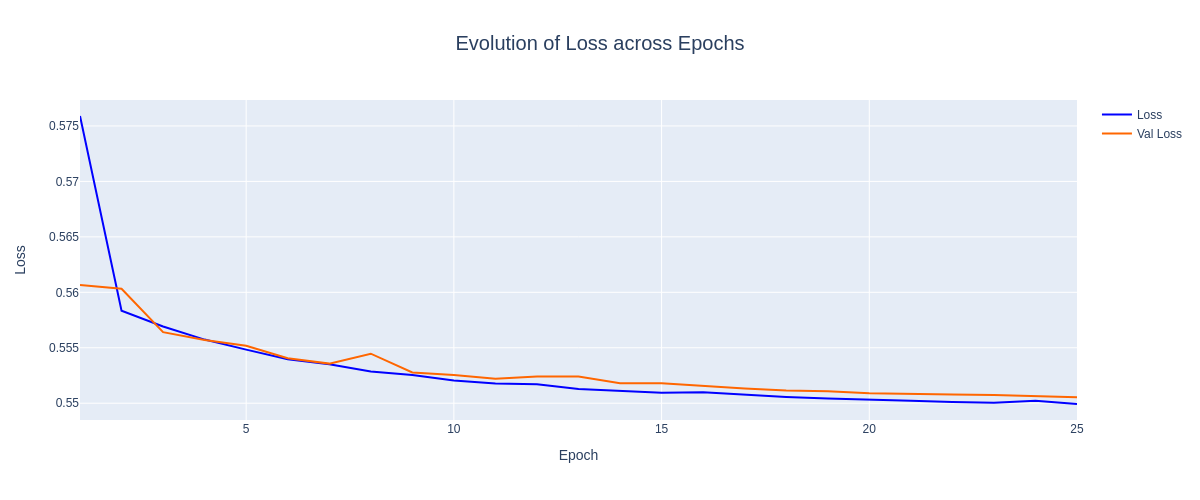

In [101]:
# Image for GitHub
plot_metrics(history, renderer="png")

In [102]:
# Dataset Evaluation
print(autoencoder_model.evaluate(train_dataset))
print(autoencoder_model.evaluate(test_dataset))

391/391 [==============================] - 3s 8ms/step - loss: 0.5496
0.5496060252189636
79/79 [==============================] - 1s 7ms/step - loss: 0.5505
0.5505484938621521


There is no overfitting observed.

**Test set results**

In [103]:
# Get images from test_dataset as numpy arrays
images  = test_dataset.unbatch().map(lambda x, y: x).as_numpy_iterator()
images = np.array(list(images))

images.shape

(10000, 32, 32, 3)

In [104]:
# Predictions
latent_rep = encoder_model.predict(images, batch_size=batch_size, verbose=0)
gen_images = autoencoder_model.predict(images, batch_size=batch_size, verbose=0)

latent_rep.shape, gen_images.shape

((10000, 8, 8, 3), (10000, 32, 32, 3))

In [105]:
names = ["Images", "Latent Representation", "Generated Images"]

In [ ]:
# Create the images folder
drive.mount("/content/drive")

directory_images = "/content/drive/MyDrive/images/autoencoder"
os.makedirs(directory_images, exist_ok=True)

In [107]:
# Function to display images

def show_images(images_noisy, latent_rep, gen_images,
                save=False, num_examples=25, names=names, random=True, cmap="gray"):

  indices = np.arange(len(images_noisy))
  if random:
    np.random.shuffle(indices)

  fig, ax = plt.subplots(num_examples, 3, figsize=(4.5, num_examples*1.5))

  for i in range(num_examples):
    ax[i, 0].imshow(images_noisy[indices[i]], cmap="gray")
    ax[i, 0].axis("off")

    ax[i, 1].imshow(latent_rep[indices[i]], cmap="gray")
    ax[i, 1].axis("off")

    ax[i, 2].imshow(gen_images[indices[i]], cmap="gray")
    ax[i, 2].axis("off")

  ax[0, 0].set_title(names[0], fontsize=7, fontweight="bold")
  ax[0, 1].set_title(names[1], fontsize=7, fontweight="bold")
  ax[0, 2].set_title(names[2], fontsize=7, fontweight="bold")

  if save:
    plt.savefig(os.path.join(directory_images, "ConvAutoencoder_CIFAR10.png"),
                transparent=True)

  plt.show()

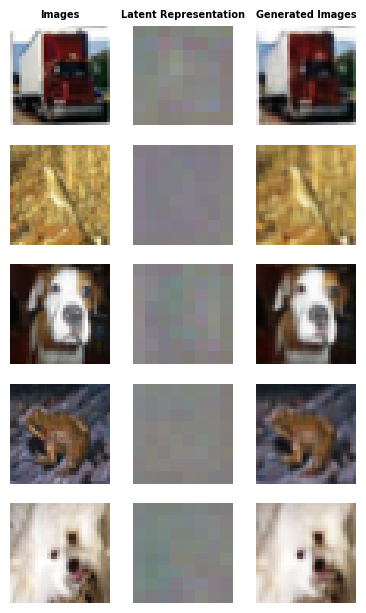

In [115]:
show_images(images, latent_rep, gen_images, num_examples=5)

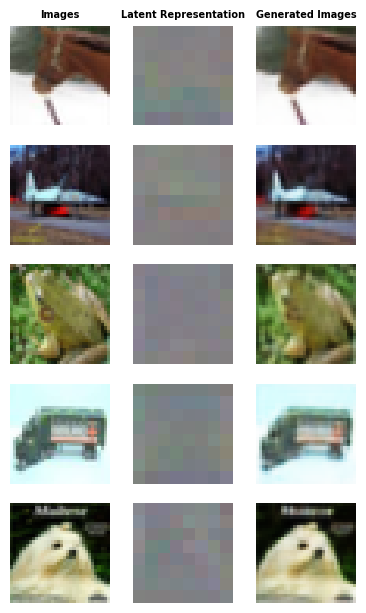

In [117]:
# Save an image with some examples
show_images(images, latent_rep, gen_images, save=True, random=False, num_examples=5)

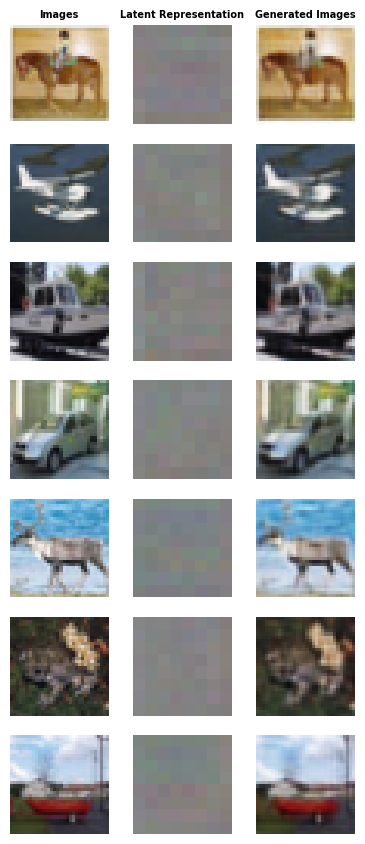

In [114]:
show_images(images, latent_rep, gen_images, num_examples=7)